# PV Model

Calculated a simulated Power Production based on this approximated formula:
```power ~ (ghi + lnghi) * (tmp + ghi)```

It will be used **power** and **ghi** normalized data according the annual cycle model.

#### References:
- [Documentation.](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.from_formula.html#statsmodels.regression.linear_model.OLS.from_formula)
- [Example.](http://songhuiming.github.io/pages/2016/07/12/statsmodels-regression-examples/)

In [1]:
%matplotlib inline
import os
import sys
sys.path.append('../')
from tools.reader import csv2df
import pandas as pd
import numpy as np
from irradiance.annual_cycle import normalizer_gam

### arguments

In [2]:
folder_input = '/media/juan/STORAGE/DATA/projects/project-energy_system/forecast-solar_power-1station/inputs/processed/grid_original_tokyo-npoints_1/dataxy'
file_input = 'data-xy-npoints_1-steps_0-23.csv'

### load data

In [3]:
# read data
ddt = {'lcol':['dt'], 'sformat':"%Y-%m-%d %H:%M:%S"}
usecols = ['dt', 'year', 'doy', 'hour', 'TMP267', 'DSWRF267', 'y']
data, dcol = csv2df(os.path.join(folder_input, file_input), ltarget=['y'], lindex = ['dt'], ddt = ddt, usecols = usecols)
# rename columns
data.rename(columns = {'TMP267':'tmp', 'DSWRF267':'ghi', 'y':'power'}, inplace=True)
# filter rows
data = data.dropna()

## MODELIZATION

In [4]:
# arguments
svar_tmp = 'tmp'
svar_ghi = 'ghi'
# other arguments
svar_power = 'power'
ihour = 11

In [5]:
# collect per hour
hourly = data[data.hour==ihour]
# data preparation
hourly['lnghi'] = np.log(hourly['ghi'].values)

/home/juan/miniconda3/envs/solar/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [6]:
## normalization 2
y_norm, y_filtered = normalizer_gam.HourlyGAM(hourly['doy'].values, hourly[svar_power].values, fraction=.2, quartile=.5)
hghi_norm, hghi_filtered = normalizer_gam.HourlyGAM(hourly['doy'].values, hourly[svar_ghi].values, fraction=.2, quartile=.5)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ihourly = scaler.fit_transform(hourly[['power','ghi','tmp', 'lnghi']])
idata = pd.DataFrame(ihourly, columns = ['power','ghi','tmp', 'lnghi'])

/home/juan/miniconda3/envs/solar/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
/home/juan/miniconda3/envs/solar/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/juan/miniconda3/envs/solar/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [7]:
idata[svar_power] = y_norm
idata[svar_ghi] = hghi_norm

In [81]:
# split datasets
nx = int(len(idata)*(1/2))
idata_train = idata[:nx]
idata_test = idata[nx:]
len(idata_train), len(idata_test)

(542, 543)

In [82]:
## formula
sformula = 'power ~ (ghi + lnghi) * (tmp + ghi)'

In [83]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

linreg = smf.ols(formula=sformula, data=idata_train[['power','ghi','tmp', 'lnghi']]).fit()


In [84]:
power_hat = linreg.predict(idata_test[['ghi','tmp', 'lnghi']])

/home/juan/miniconda3/envs/solar/lib/python3.6/site-packages/statsmodels/base/model.py:775: DeprecationWarning: The DesignInfo.builder attribute is deprecated starting in patsy v0.4.0; distinct builder objects have been eliminated and design_info.builder is now just a long-winded way of writing 'design_info' (i.e. the .builder attribute just returns self)
  exog = dmatrix(self.model.data.design_info.builder,


/home/juan/miniconda3/envs/solar/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


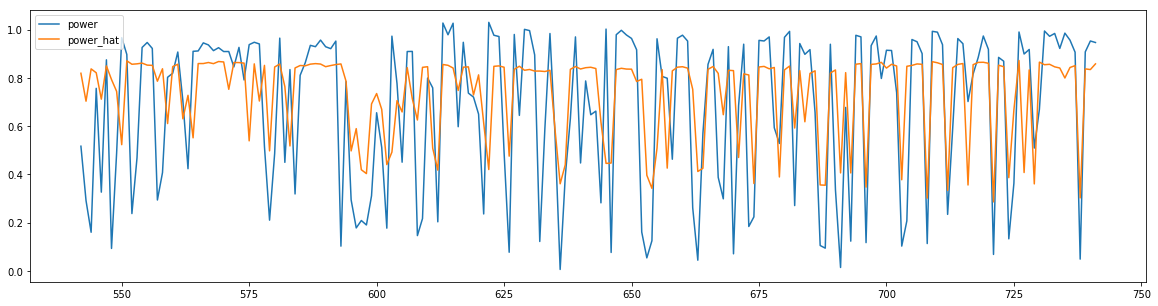

In [90]:
idata_test['power_hat'] = power_hat
idata_test[['power','power_hat']][:200].plot(figsize=(20,5))

In [53]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.metrics import r2_score
from pandas import DataFrame
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
sys.path.append('../')
from models.metrics import metrics_regression
import warnings
warnings.filterwarnings('ignore')

class LRFormula(BaseEstimator, RegressorMixin):  
    """
    Simple Linear Regression by formula
    """

    def __init__(self, formula:str, colnames_X:list , colname_y:str):
        """
        Initializing the regressor
        """
        self.formula = formula
        self.colnames_X = colnames_X
        self.colname_y = colname_y
        
    def fit(self, X, y):
        """
        Fit the model.
        """
        # validation: check that X and y have correct shape
        X, y = check_X_y(X, y)   
        # set as attributes
        self.X_ = X
        self.y_ = y
        # validation: check that X and colnames_X have correct shape
        assert (len(self.colnames_X) == X.shape[1]), "colnames no match with the data shape."
        # data to df
        dfxy = DataFrame(np.c_[X, y], columns = self.colnames_X + [self.colname_y])
        # fit the model
        try:
            self.linreg = smf.ols(formula=self.formula, data=dfxy).fit()
        except Exception as e:
            print(str(e))
        # return
        return self


    def predict(self, X, y=None):
        """
        Calculate prediction.
        """
        # check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        # input validation
        X = check_array(X)
        # data to df
        dfx = DataFrame(X, columns = self.colnames_X)
        # prediction
        return self.linreg.predict(dfx).values.ravel()

    def score(self, X, y=None):
        # validation: check that X and y have correct shape
        X, y = check_X_y(X, y)  
        # calculate and retur
        return r2_score(y, self.predict(X))
    
    def metrics(self, X, y):
        # validation: check that X and y have correct shape
        X, y = check_X_y(X, y)  
        # calculate and return metrics
        return metrics_regression(y, self.predict(X))
        
    def summary(self):
        # check is fit had been called
        check_is_fitted(self, ['X_', 'y_'])
        # display summary
        print(self.linreg.summary())
        return None

In [54]:
colnames_X = ['ghi','tmp', 'lnghi']
colname_y = 'power'
formula = 'power ~ (ghi + lnghi) * (tmp + ghi)'
X = idata[colnames_X]
y = idata[colname_y].values

clf = LRFormula(formula, colnames_X, colname_y)
clf.fit(X,y)
clf.score(X,y)

0.30682916589979425

In [55]:
from sklearn.model_selection import cross_val_score
clf = LRFormula(formula, colnames_X, colname_y)
cross_val_score(clf, X, y, cv=5, n_jobs=-1, scoring='r2')

array([ 0.23781184,  0.3799984 ,  0.23493189,  0.43984731,  0.14987774])

In [56]:
from sklearn.model_selection import cross_val_predict
clf = LRFormula(formula, colnames_X, colname_y)
cross_val_predict(clf, X, y, cv=5, n_jobs=-1, method='predict')

array([ 0.85669094,  0.84467758,  0.86941377, ...,  0.86632393,
        0.85686116,  0.27680639])

In [58]:
clf.fit(X,y)
clf.summary()

                            OLS Regression Results                            
Dep. Variable:                  power   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     79.53
Date:                Wed, 19 Sep 2018   Prob (F-statistic):           2.26e-82
Time:                        18:54:17   Log-Likelihood:                -119.61
No. Observations:                1085   AIC:                             253.2
Df Residuals:                    1078   BIC:                             288.1
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1202      0.071      1.695      0.0